## Simple DSGE Model with Labor Choice

Household budget constraint
$ c_t = w_t\ell_t+(1+ r_t-\delta)k_t - k_{t+1} $ (1)

Intertemporal Euler equation
$ u_c(c_t,\ell_t) = \beta E_t\left\{ u_c(c_{t+1},\ell_{t+1})(1 + r_{t+1}-\delta) \right\} $ (2)

Labor-leisure Euler equation
$ -u_{\ell}(c_t,\ell_t) = u_{c}(c_t,\ell_t)w_t $ (3)

Results from Firm's problem
$ r_t = f_K(k_t,\ell_t,z_t) $ (4)
$ w_t = f_L(k_t,\ell_t,z_t) $ (5)

Law of motion for technology
$ z_t = \rho_z z_{t-1}+ \epsilon^z_t ;\quad \epsilon^z_t\sim\text{i.i.d.}(0,\sigma_z^2) $ (6)

Utility function
$ u_t = \frac{c_t^{1-\gamma}-1}{1-\gamma} - \chi \frac{\ell^{1+\theta}}{1+\theta} $ (7)

Production function
$ Y_t = k_t^\alpha (e^{z_t} \ell_t )^{1-\alpha} $ (8)

with the following parameter values:

$\alpha = .35, \beta = .99, \gamma = 2.5, \delta = .08, \chi = 10.0, \theta = 2.0, \rho = .9, \sigma = .01$.

The variables are categorized as:

$ X_t = \left\{k_{t-1}\right\} $, defined by equation (2).

$ Y_t = \left\{\ell_t,\right\} $, defined by equation (3).

$ Z_t = \left\{z_t\right\} $, defined by equation (6).

$ D_t = \left\{c_t,w_t,r_t,u_t,Y_t\right\} $, defined by equations (1), (4), (5), (7) and (8).



We use the same definitions function and dynamic function as homework 5.  Note that the function `Modeldyn` is the $\Gamma\{X_{t+1}, X_t, X_{t-1}, Y_{t+1}, Y_t, Z_{t+1}, Z_t \}$ from the notes and the lecture.

In [71]:
def Modeldefs(Xp, X, Y, Z, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns explicitly defined
    values for consumption, gdp, wages, real interest rates, and transfers
    
    Inputs are:
        Xp: value of capital in next period
        X: value of capital this period
        Y: value of labor this period
        Z: value of productivity this period
        params: list of parameter values
    
    Outputs are:
        GDP: GDP
        w: wage rate
        r: rental rate on capital
        T: transfer payments
        c: consumption
        i: investment
        u: utiity
    '''
    
    # unpack input vectors
    kp = Xp
    k = X
    ell = Y
    z = Z
    
    # truncate labor if necessary
    if ell > 0.9999:
        ell = 0.9999
    elif ell < 0.0001:
        ell = 0.0001
    
    # unpack params
    [alpha, beta, gamma, delta, xi, a, rho, sigma, tau] = params
    
    # find definintion values
    GDP = k**alpha*(np.exp(z)*ell)**(1-alpha)
    w = (1-alpha)*GDP/ell
    r = alpha*GDP/k
    T = (w*ell + (r - delta)*k)*tau
    c = (1-tau)*(w*ell + (r - delta)*k) + k + T - kp
    i = GDP - c
    
    u = (c**(1-gamma)-1)/(1-gamma) + a*((1-ell)**(1-xi) - 1)/(1-xi)

    return GDP, w, r, c, i, u, T


def Modeldyn(theta0, params):
    '''
    This function takes vectors of endogenous and exogenous state variables
    along with a vector of 'jump' variables and returns values from the
    characterizing Euler equations.
    
    Inputs are:
        theta: a vector containng (Xpp, Xp, X, Yp, Y, Zp, Z) where:
            Xpp: value of capital in two periods
            Xp: value of capital in next period
            X: value of capital this period
            Yp: value of labor in next period
            Y: value of labor this period
            Zp: value of productivity in next period
            Z: value of productivity this period
        params: list of parameter values
    
    Output are:
        Euler: a vector of Euler equations written so that they are zero at the
            steady state values of X, Y & Z.  This is a 2x1 numpy array. 
    '''
    
    # unpack theat0
    (Xpp, Xp, X, Yp, Y, Zp, Z) = theta0
    
    # unpack params
    [alpha, beta, gamma, delta, xi, a, rho, sigma, tau] = params
    
    # find definitions for now and next period
    ell = Y
    if ell > 1:
        ell = 0.9999
    elif ell < 0.0001:
        ell = 0.0001
    GDP, w, r, c, i, u, T = Modeldefs(Xp, X, Y, Z, params)
    GDPp, wp, rp, cp, ip, up, Tp = Modeldefs(Xpp, Xp, Yp, Zp, params)
    
    # Evaluate Euler equations
    E1 = (c**(-gamma)*w*(1-tau)) - a*(1-ell)**(-xi)
    E2 = (c**(-gamma)) - (beta * cp**(-gamma))*((rp-delta)*(1-tau) + 1)
    
    return np.array([E1, E2])

We will be using the `LinApp` toolkit which can be downloaded at `https://github.com/kerkphil/DSGE-Utilities`.  We need to import the functions from that toolkit.

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# import the modules from LinApp
from LinApp_FindSS import LinApp_FindSS
from LinApp_Deriv import LinApp_Deriv
from LinApp_Solve import LinApp_Solve
from LinApp_SSL import LinApp_SSL

We next define and setup a model parameters vector, along with other parameters needed by `LinApp_FindSS`.

In [73]:
# set parameter values
alpha = .40
beta = .98
gamma = 2.5
delta = .10
xi = 1.5
a = .5
rho = .9
sigma = .01
tau = .05

# make parameter list to pass to functions
params = np.array([alpha, beta, gamma, delta, xi, a, rho, sigma, tau])

# set LinApp parameters
Zbar = np.array([0.])
nx = 1  # number of X variables
ny = 1  # number of Y variables
nz = 1  # number of Z variables
logX = 0  # 1 if log-linearizing, otherwise 0
Sylv = 0  # just set this to 0 for now.

Now we can use `fsolve` to find the steady state values.  `LinApp_FindSS` does this very quickly and easily for us.

In [74]:
# take a guess for steady state values of k and ell
guessXY = np.array([.5, .5])

# find the steady state values using LinApp_FindSS
XYbar = LinApp_FindSS(Modeldyn, params, guessXY, Zbar, nx, ny)
(kbar, ellbar) = XYbar

# set up steady state input vector
theta0 = np.array([kbar, kbar, kbar, ellbar, ellbar, 0., 0.])

# check SS solution
check = Modeldyn(theta0, params)
print ('check SS: ', check)
if np.max(np.abs(check)) > 1.E-6:
    print ('Have NOT found steady state')
    
# find the steady state values for the definitions
Ybar, wbar, rbar, cbar, ibar, ubar, tbar = \
    Modeldefs(kbar, kbar, ellbar, 0., params)

# display all steady state values
print ('kbar:   ', kbar)
print ('ellbar: ', ellbar)
print ('Ybar:   ', Ybar)
print ('wbar:   ', wbar)
print ('rbar:   ', rbar)
print ('cbar:   ', cbar)
print ('ibar:   ', ibar)
print ('ubar:   ', ubar)
print ('tbar:   ', tbar)

check SS:  [-1.47215573e-13 -2.30926389e-13]
kbar:    4.225229026773769
ellbar:  0.5797914531669756
Ybar:    1.2832261088313197
wbar:    1.3279527683500643
rbar:    0.12148227712154526
cbar:    0.8607032061539437
ibar:    0.422522902677376
ubar:    -0.7108726381180849
tbar:    0.04303516030769715


We now use the `LinApp` toolkit to get the linear coefficients.

In [78]:
# find the derivatives matrices
[AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM] = \
   LinApp_Deriv(Modeldyn, params, theta0, nx, ny, nz, logX)

# set value for NN    
NN = rho
    
# find the policy and jump function coefficients
PP, QQ, RR, SS = LinApp_Solve(AA, BB, CC, DD, FF, GG, HH, JJ, KK, LL, MM, NN, Zbar, Sylv)
print("F: ", FF)
print("G: ", GG)
print("H: ", HH)
print("L: ", LL)
print("M: ", MM)
print("N: ", NN)
print('P: ', PP)
print('Q: ', QQ)


F:  [[-4.2262291]]
G:  [[8.56661569]]
H:  [[-4.31701813]]
L:  [[3.15518743]]
M:  [[-3.25392451]]
N:  0.9
P:  [[0.9152937]]
Q:  [[0.54504228]]


#### Now similate this for 50 periods with a shock in period 10 and plot the IRFs.

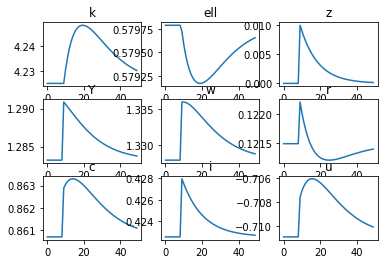

In [81]:
# set number of observations
nobs = 50 

# create a history of z's using equation (7)
zhist = np.zeros(nobs+1)
#epshist = sigma*np.random.normal(0., 1., nobs+1)
epshist = np.zeros(nobs+1)
epshist[9] = sigma
zhist[0] = epshist[0]
for t in range(1,nobs+1):
    zhist[t] = rho*zhist[t-1] + epshist[t]
    
# LinApp_SSL requires that Zhist be a 2-dimensional array
Zhist = np.reshape(zhist, (nobs+1, 1))

# Linapp_SSL also requires that starting values be arrays
k0 = np.array([[kbar]])
ell0 = np.array([[ellbar]])

# create a history of k's and ell's using LinApp_SSL
khist, ellhist =  LinApp_SSL(k0, Zhist ,XYbar, logX, PP, QQ, RR, SS)

# create histories of remaining variables
Yhist = np.zeros(nobs)
whist = np.zeros(nobs)
rhist = np.zeros(nobs)
chist = np.zeros(nobs)
ihist = np.zeros(nobs)
uhist = np.zeros(nobs)
thist = np.zeros(nobs)
for t in range(0,nobs):
    Yhist[t], whist[t], rhist[t], chist[t], ihist[t], uhist[t], thist[t] = \
        Modeldefs(khist[t+1], khist[t], ellhist[t], zhist[t], params)
        
# delete last observation
khist = khist[0:nobs]
zhist = zhist[0:nobs]
ellhist = ellhist[0:nobs]

# plot time series
time = range(0, nobs)

fig = plt.figure()
plt.subplot(3,3,1)
plt.plot(time, khist, label='k')
plt.title('k')
plt.subplot(3,3,2)
plt.plot(time, ellhist, label='ell')
plt.title('ell')
plt.subplot(3,3,3)
plt.plot(time, zhist, label='z')
plt.title('z')
plt.subplot(3,3,4)
plt.plot(time, Yhist, label='Y')
plt.title('Y')
plt.subplot(3,3,5)
plt.plot(time, whist, label='w')
plt.title('w')
plt.subplot(3,3,6)
plt.plot(time, rhist, label='r')
plt.title('r')
plt.subplot(3,3,7)
plt.plot(time, chist, label='c')
plt.title('c')
plt.subplot(3,3,8)
plt.plot(time, ihist, label='i')
plt.title('i')
plt.subplot(3,3,9)
plt.plot(time, uhist, label='u')
plt.title('u')
plt.show()